In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Sun Jan 22 14:09:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt
from  IPython import display

import pathlib
import shutil
import tempfile

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import warnings
warnings.filterwarnings('ignore')

In [5]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.9.2
Hub version:  0.12.0
GPU is available


In [6]:
# Reading the csv 
df = pd.read_csv("/content/drive/MyDrive/PE-2/Fianl_data.csv")
# Dropping any rows with missing values
df.dropna(inplace=True)
df_pos = df[df['sentiment']=='Positive'].iloc[:80000] # contains positive reviews
df_neg = df[df['sentiment']=='Negative'].iloc[:80000] # contains negative reviews
# concatenating both two dataframes
frames = [df_pos, df_neg]
result = pd.concat(frames)
# Shuffling the rows
result = result.sample(frac=1).reset_index(drop=True) 
# Mapping target to numerical values
dict_map = {'Negative': 0, 'Positive': 1, 'Neural':2}
result["sentiment"] = result["sentiment"].map(dict_map)

In [7]:
from sklearn.model_selection import train_test_split
# splitting the dataframe into train, validation and test sets with 80%, 20% of the data respectively
train_df, remaning = train_test_split(result, random_state=42, train_size=0.8, stratify=result.sentiment.values) 
validation_df, _ = train_test_split(remaning, random_state=42, train_size=0.4, stratify=remaning.sentiment.values) 

In [8]:
validation_df.shape

(12800, 3)

In [9]:
train_df.shape

(128000, 3)

In [10]:
MODULE_URL = "https://tfhub.dev/google/universal-sentence-encoder-large/5" 

In [11]:
embedding_layer = hub.KerasLayer(MODULE_URL, input_shape=[], output_shape=[512], dtype=tf.string, trainable=False)

In [12]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='best_model.h5',
                               monitor='val_acc',
                               save_best_only=True,
                               mode='max')

In [13]:
model = tf.keras.models.Sequential([
        embedding_layer,
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               147354880 
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 147,502,721
Trainable params: 147,841
Non-trainable params: 147,354,880
_________________________________________________________________


In [15]:
model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    )

In [16]:
history = {}

history['universal-sentence-encoder-large'] = model.fit(
        train_df.review_body,
        train_df.sentiment,
        epochs = 5,
        callbacks=[checkpointer],
        validation_data = (validation_df.review_body, validation_df.sentiment),# validation data is tuple of feature and target
        verbose=1
    )

Epoch 1/5
3999/4000 [============================>.] - ETA: 0s - loss: 0.2332 - accuracy: 0.9111

4000/4000 [==============================] - 266s 60ms/step - loss: 0.2332 - accuracy: 0.9111 - val_loss: 0.2042 - val_accuracy: 0.9192
Epoch 2/5
4000/4000 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.9248

4000/4000 [==============================] - 233s 58ms/step - loss: 0.1934 - accuracy: 0.9248 - val_loss: 0.1965 - val_accuracy: 0.9216
Epoch 3/5
4000/4000 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.9295

4000/4000 [==============================] - 244s 61ms/step - loss: 0.1837 - accuracy: 0.9295 - val_loss: 0.1902 - val_accuracy: 0.9245
Epoch 4/5
4000/4000 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9328

4000/4000 [==============================] - 258s 65ms/step - loss: 0.1755 - accuracy: 0.9328 - val_loss: 0.1882 - val_accuracy: 0.9277
Epoch 5/5
4000/4000 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 0.9358

4000/4000 [==============================] - 234s 59ms/step - loss: 0.1680 - accuracy: 0.9358 - val_loss: 0.1806 - val_accuracy: 0.9302


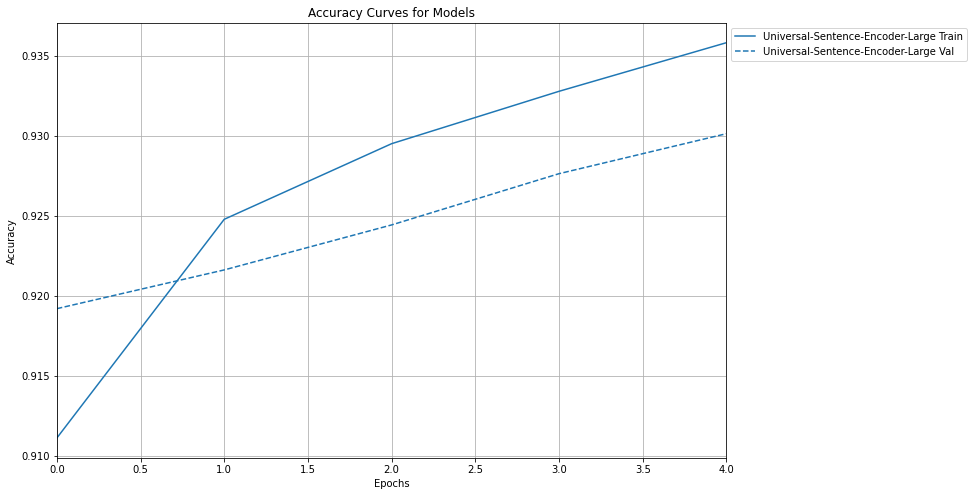

In [21]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(history)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

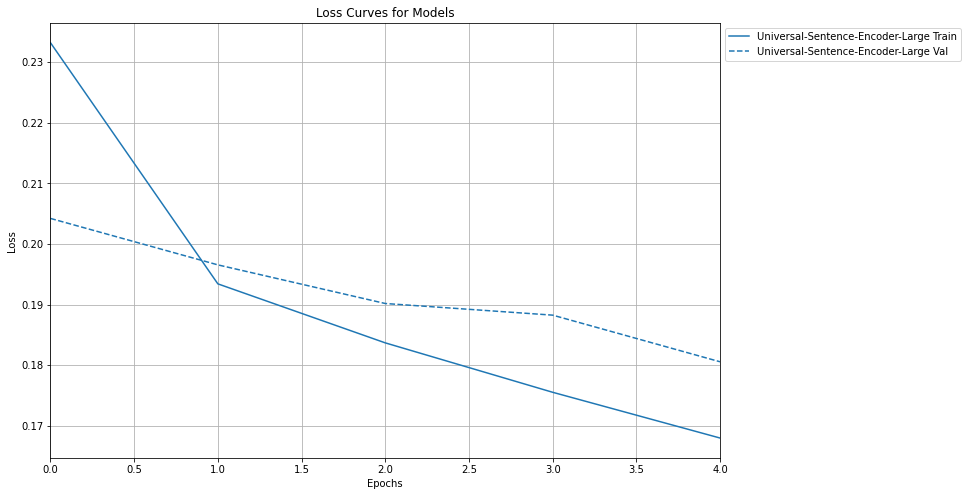

In [22]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(history)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

# **Universal Sentence Encoder**

**Runtime** ~ 21mins

**GPU-** NVIDIA-SMI 460.32.03

**Total params:** 147,502,721

**Trainable params:** 147,841

Non-trainable params: 147,354,880

In [23]:
!mkdir -p saved_model
model.save('/content/drive/MyDrive/PE-2/saved_model/universal-sentence-encoder-large')